In [ ]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import cifar10
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

In [ ]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    # Get number of available GPUs-
    num_gpus = len(tf.config.list_physical_devices('GPU'))
    print(f"number of GPUs available = {num_gpus}")

    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

number of GPUs available = 1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: Tesla T4


In [ ]:
# input image dimensions
img_rows, img_cols = 32, 32

In [ ]:
# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [ ]:
# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 300

In [ ]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [ ]:
# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [ ]:
print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape} & X_test.shape: {X_test.shape}")


Dimensions of training and testing sets are:
X_train.shape: (50000, 32, 32, 3) & X_test.shape: (10000, 32, 32, 3)


In [ ]:
# Create TF datasets-
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(50000).batch(batch_size = batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).shuffle(10000).batch(batch_size = batch_size)

# Needed by 'tf.GradientTape()' API for custom training and testing code.

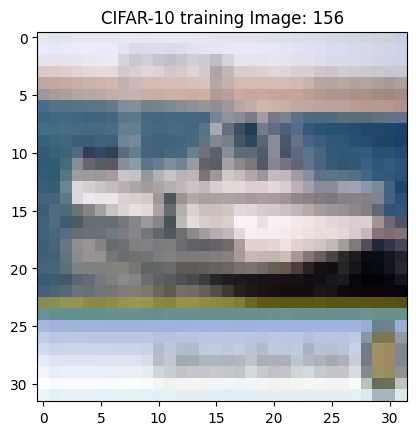

In [ ]:
# Visualize one CIFAR-10 dataset-
img_idx = 155

plt.imshow(X_train[img_idx])
plt.title(f"CIFAR-10 training Image: {img_idx + 1}")
plt.show()

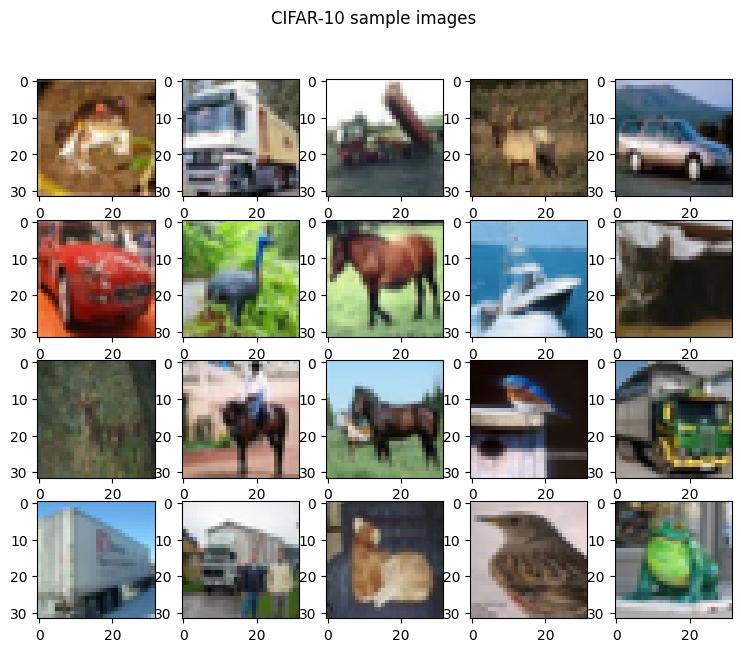

In [ ]:
# Visualize 20 CIFAR-10 images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train[i], cmap = plt.get_cmap('gray'))

plt.suptitle("CIFAR-10 sample images")
plt.show()

In [ ]:
class ConvBlock(Model):
    def __init__(
        self, num_filters,
        kernel_size, stride_length,
        pooling_size, pooling_stride,
        padding_type = 'same'
    ):
        super(ConvBlock, self).__init__()

        self.conv1 = Conv2D(
            filters = num_filters, kernel_size = kernel_size,
            strides = stride_length, padding = padding_type,
            activation = None, use_bias = False,
        )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv2 = Conv2D(
            filters = num_filters, kernel_size = kernel_size,
            strides = stride_length, padding = padding_type,
            activation = None, use_bias = False
        )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.pool = MaxPooling2D(
            pool_size = pooling_size,
            strides = pooling_stride
        )


    def call(self, x):
        x = tf.keras.activations.relu(self.bn(self.conv1(x)))
        x = tf.keras.activations.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        return x


In [ ]:
class Conv6_Encoder(Model):
    def __init__(self, latent_dim = 10):
        super(Conv6_Encoder, self).__init__()

        self.latent_dim = latent_dim

        self.conv_block1 = ConvBlock(
            num_filters = 64, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'valid'
            )

        self.conv_block2 = ConvBlock(
            num_filters = 128, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'valid'
            )

        self.conv_block3 = ConvBlock(
            num_filters = 256, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'same'
            )

        self.flatten = Flatten()

        self.output_layer = Dense(
            units = self.latent_dim, activation = None
            )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )


    def call(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = tf.keras.activations.relu(self.bn(self.output_layer(x)))
        return x


    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv_block1(x)
        print(f"conv_block1.shape: {x.shape}")
        x = self.conv_block2(x)
        print(f"conv_block2.shape: {x.shape}")
        x = self.conv_block3(x)
        print(f"conv_block3.shape: {x.shape}")
        x = self.flatten(x)
        print(f"flattened shape: {x.shape}")
        x = tf.keras.activations.relu(self.bn(self.output_layer(x)))
        print(f"Encoder output shape: {x.shape}")
        '''
        Input shape: (64, 32, 32, 3)
        conv_block1.shape: (64, 14, 14, 64)
        conv_block2.shape: (64, 5, 5, 128)
        conv_block3.shape: (64, 2, 2, 256)
        flattened shape: (64, 1024)
        Encoder output shape: (64, 100)
        '''

        return None


In [ ]:
class Conv6_Decoder(Model):
    def __init__(self, latent_dim = 10):
        super(Conv6_Decoder, self).__init__()

        self.latent_dim = latent_dim

        # self.inp_layer = InputLayer(input_shape = self.latent_dim)

        self.dense0 = Dense(
            units = self.latent_dim, activation = None
            )
        self.bn0 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.dense = Dense(
            units = 1024, activation = None
        )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.dense2 = Dense(
            units = 4 * 4 * 256, activation = None
        )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.reshape = Reshape((4, 4, 256))

        self.conv_transpose_layer1 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn3 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer2 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )

        self.bn4 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer3 =  Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn5 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer4 = Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )

        self.bn6 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer5 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn7 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer6 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )

        self.bn8 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.final_conv_layer = Conv2DTranspose(
            filters = 3, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )


    def call(self, X):
        # X = self.inp_layer(X)
        X = tf.keras.activations.relu(self.bn0(self.dense0(X)))
        X = tf.keras.activations.relu(self.bn(self.dense(X)))
        X = tf.keras.activations.relu(self.bn2(self.dense2(X)))
        X = self.reshape(X)
        X = tf.keras.activations.relu(self.bn3(self.conv_transpose_layer1(X)))
        X = tf.keras.activations.relu(self.bn4(self.conv_transpose_layer2(X)))
        X = tf.keras.activations.relu(self.bn5(self.conv_transpose_layer3(X)))
        X = tf.keras.activations.relu(self.bn6(self.conv_transpose_layer4(X)))
        X = tf.keras.activations.relu(self.bn7(self.conv_transpose_layer5(X)))
        X = tf.keras.activations.relu(self.bn8(self.conv_transpose_layer6(X)))
        # X = tf.keras.activations.sigmoid(self.final_conv_layer(X))
        X = self.final_conv_layer(X)

        return X


    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = tf.nn.relu(self.bn0(self.dense0(x)))
        print(f"first dense layer shape: {x.shape}")
        x = tf.nn.relu(self.bn(self.dense(x)))
        print(f"second dense layer shape: {x.shape}")
        x = tf.nn.relu(self.bn2(self.dense2(x)))
        print(f"third dense layer shape: {x.shape}")
        x = self.reshape(x)
        print(f"reshape: {x.shape}")
        x = tf.nn.relu(self.bn3(self.conv_transpose_layer1(x)))
        print(f"conv transpose layer1 shape: {x.shape}")
        x = tf.nn.relu(self.bn4(self.conv_transpose_layer2(x)))
        print(f"conv transpose layer2 shape: {x.shape}")
        x = tf.nn.relu(self.bn5(self.conv_transpose_layer3(x)))
        print(f"conv transpose layer3 shape: {x.shape}")
        x = tf.nn.relu(self.bn6(self.conv_transpose_layer4(x)))
        print(f"conv transpose layer4 shape: {x.shape}")
        x = tf.nn.relu(self.bn7(self.conv_transpose_layer5(x)))
        print(f"conv transpose layer5 shape: {x.shape}")
        x = tf.nn.relu(self.bn8(self.conv_transpose_layer6(x)))
        print(f"conv transpose layer6 shape: {x.shape}")
        x = self.final_conv_layer(x)
        print(f"Decoder output shape: {x.shape}")

        '''
        Input shape: (64, 100)
        first dense layer shape: (64, 100)
        second dense layer shape: (64, 1024)
        third dense layer shape: (64, 4096)
        reshape: (64, 4, 4, 256)
        conv transpose layer1 shape: (64, 8, 8, 256)
        conv transpose layer2 shape: (64, 8, 8, 256)
        conv transpose layer3 shape: (64, 16, 16, 128)
        conv transpose layer4 shape: (64, 16, 16, 128)
        conv transpose layer5 shape: (64, 32, 32, 64)
        conv transpose layer6 shape: (64, 32, 32, 64)
        Decoder output shape: (64, 32, 32, 3)
        '''

        return None


In [ ]:
class Sampling(tf.keras.layers.Layer):
    """
    Create a sampling layer.
    Uses (mu, log_var) to sample latent vector 'z'.
    """
    def call(self, mu, log_var):
    # def call(self, inputs):
        # z_mean, z_log_var = inputs

        # Get batch size-
        batch = tf.shape(mu)[0]

        # Get latent space dimensionality-
        dim = tf.shape(mu)[1]

        # Add stochasticity by sampling from a multivariate standard
        # Gaussian distribution-
        epsilon = tf.keras.backend.random_normal(
            shape = (batch, dim), mean = 0.0,
            stddev = 1.0
        )

        return mu + (tf.exp(0.5 * log_var) * epsilon)


In [ ]:
class VAE(Model):
    def __init__(self, latent_space = 100):
        super(VAE, self).__init__()

        self.latent_space = latent_space

        self.encoder = Conv6_Encoder(latent_dim = self.latent_space)
        self.decoder = Conv6_Decoder(latent_dim = self.latent_space)

        # Define fully-connected layers for computing mean & log variance-
        self.mu = Dense(units = self.latent_space, activation = None)
        self.log_var = Dense(units = self.latent_space, activation = None)


    def reparameterize(self, mu, logvar):
        # Sample from a multivariate Gaussian distribution.
        # Adds stochasticity or variation-
        eps = tf.random.normal(
            shape = mu.shape, mean = 0.0,
            stddev = 1.0
        )
        return (eps * tf.exp(logvar * 0.5) + mu)


    def call(self, x):
        x = self.encoder(x)
        # print(f"x.shape: {x.shape}")
        # x.shape: (batch_size, 100)

        mu = self.mu(x)
        log_var = self.log_var(x)
        # z = self.reparameterize(mu, log_var)
        # z = Sampling()([mu, log_var])
        z = Sampling()(mu, log_var)
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape}"
              f" & z.shape: {z.shape}")
        # mu.shape: (batch_size, 100), log_var.shape: (batch_size, 100) & z.shape: (batch_size, 100)
        '''

        x = tf.keras.activations.sigmoid(self.decoder(z))
        return x, mu, log_var


    def model(self):
        '''
        Overrides 'model()' call.
        Output shape is not well-defined when using sub-classing. As a
        workaround, this method is implemeted.
        '''
        x = Input(shape = (32, 32, 3))
        return Model(inputs = [x], outputs = self.call(x))



In [ ]:
# Initialize VAE model-
model = VAE(latent_space = 100)

In [ ]:
# Sanity check-
x = next(iter(train_dataset))

In [ ]:
# Forward pass using input data-
x_recon, mu, log_var = model(x)

In [ ]:
x.shape, x_recon.shape

(TensorShape([64, 32, 32, 3]), TensorShape([64, 32, 32, 3]))

In [ ]:
mu.shape, log_var.shape

(TensorShape([64, 100]), TensorShape([64, 100]))

In [ ]:
mu.numpy().mean(), mu.numpy().std()

(-0.000100961486, 0.013041143)

In [ ]:
log_var.numpy().mean(), log_var.numpy().std()

(-0.0016546017, 0.012242828)

In [ ]:
del x, x_recon, mu, log_var

In [ ]:
# Get model summary-
model.model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv6__encoder_1 (Conv6_En  (None, 100)                  1250996   ['input_1[0][0]']             
 coder)                                                                                           
                                                                                                  
 dense_8 (Dense)             (None, 100)                  10100     ['conv6__encoder_1[0][0]']    
                                                                                                  
 dense_9 (Dense)             (None, 100)                  10100     ['conv6__encoder_1[0][0]']

In [ ]:
# Count layer-wise number of trainable parameters-
tot_params = 0

for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params += loc_params
    print(f"layer: {layer.shape} has {loc_params} parameters")

layer: (3, 3, 3, 64) has 1728 parameters
layer: (64,) has 64 parameters
layer: (64,) has 0 parameters
layer: (3, 3, 64, 64) has 36864 parameters
layer: (64,) has 64 parameters
layer: (64,) has 0 parameters
layer: (3, 3, 64, 128) has 73728 parameters
layer: (128,) has 128 parameters
layer: (128,) has 0 parameters
layer: (3, 3, 128, 128) has 147456 parameters
layer: (128,) has 128 parameters
layer: (128,) has 0 parameters
layer: (3, 3, 128, 256) has 294912 parameters
layer: (256,) has 256 parameters
layer: (256,) has 0 parameters
layer: (3, 3, 256, 256) has 589824 parameters
layer: (256,) has 256 parameters
layer: (256,) has 0 parameters
layer: (1024, 100) has 102400 parameters
layer: (100,) has 0 parameters
layer: (100,) has 100 parameters
layer: (100,) has 0 parameters
layer: (100, 100) has 10000 parameters
layer: (100,) has 0 parameters
layer: (100,) has 100 parameters
layer: (100,) has 0 parameters
layer: (100, 1024) has 102400 parameters
layer: (1024,) has 0 parameters
layer: (1024,

In [ ]:
# Define an optimizer-
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

In [ ]:
def compute_loss(data, reconstruction, mu, log_var, alpha = 1):

    # Reconstruction loss-
    # recon_loss = tf.keras.losses.mean_squared_error(K.flatten(data), K.flatten(reconstruction))

    recon_loss = tf.reduce_mean(
        tf.reduce_sum(
            # tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            tf.keras.losses.mean_squared_error(data, reconstruction),
            axis = (1, 2)
            )
        )

    # KL-divergence loss-
    kl_loss = -0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var))
    kl_loss = tf.reduce_mean(
        tf.reduce_sum(
            kl_loss,
            axis = 1
        )
    )

    total_loss = (recon_loss * alpha) + kl_loss

    return total_loss, recon_loss, kl_loss


In [ ]:
@tf.function
def train_one_step(model, optimizer, data, alpha):
    # Function to perform one step/iteration of training

    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        data_recon, mu, log_var = model(data)

        # Compute loss-
        total_loss, recon_loss, kl_loss = compute_loss(
            data = data, reconstruction = data_recon,
            mu = mu, log_var = log_var,
            alpha = alpha
        )

    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(total_loss, model.trainable_variables)

    # type(grads)
    # list

    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, recon_loss, kl_loss


In [ ]:
@tf.function
def test_step(model, optimizer, data, alpha):
    '''
    Function to test model performance
    on testing dataset
    '''
    # Make predictions using defined model-
    data_recon, mu, log_var = model(data)

    # Compute loss-
    total_loss, recon_loss, kl_loss = compute_loss(
        data = data, reconstruction = data_recon,
        mu = mu, log_var = log_var,
        alpha = alpha
    )

    return total_loss, recon_loss, kl_loss


In [ ]:
# Python3 dict to contain training metrics-
training_metrics = {}
val_metrics = {}

In [ ]:
# Specify hyper-parameter for reconstruction loss vs. kl-divergence-
alpha = 10

In [ ]:
for epoch in range(1, num_epochs + 1):
    """
    # Manual early stopping implementation-
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    """

    # Epoch train & validation losses-
    train_loss = 0.0
    train_r_loss = 0.0
    train_kl_l = 0.0
    val_loss = 0.0
    val_r_loss = 0.0
    val_kl_l = 0.0

    for data in train_dataset:
        train_total_loss, train_recon_loss, train_kl_loss = train_one_step(
            model = model, optimizer = optimizer,
            data = data, alpha = alpha
        )

        train_loss += train_total_loss.numpy()
        train_r_loss += train_recon_loss.numpy()
        train_kl_l += train_kl_loss.numpy()

    for test_data in test_dataset:
        test_total_loss, test_recon_loss, test_kl_loss = test_step(
            model = model, optimizer = optimizer,
            data = test_data, alpha = alpha)

        val_loss += test_total_loss.numpy()
        val_r_loss += test_recon_loss.numpy()
        val_kl_l += test_kl_loss.numpy()

    # vae_train_loss.append(train_loss)
    # vae_val_loss.append(val_loss)

    training_metrics[epoch] = {
        'total_loss': train_loss, 'recon_loss': train_r_loss,
        'kl_loss': train_kl_l
        }

    val_metrics[epoch] = {
        'total_loss': val_loss, 'recon_loss': val_r_loss,
        'kl_loss': val_kl_l
    }

    print(f"epoch = {epoch}; total train loss = {train_loss:.4f},"
    f" train recon loss = {train_r_loss:.4f}, train kl loss = {train_kl_l:.4f};"
    f" total val loss = {val_loss:.4f}, val recon loss = {val_r_loss:.4f} &"
    f" val kl loss = {val_kl_l:.4f}"
    )

    '''
    # Save 'best' model so far-
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"Saving VAE model with val_los = {val_loss:.4f}")
        model.save_weights("VAE_CIFAR10_best_model.h5", overwrite = True)
    '''

    """
    # Code for manual Early Stopping:
    # if np.abs(val_loss < best_val_loss) >= minimum_delta:
    if (val_loss < best_val_loss) and \
    (np.abs(val_loss - best_val_loss) >= minimum_delta):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss

        # reset 'loc_patience' variable-
        loc_patience = 0

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")

        # Save trained model with 'best' validation accuracy-
        model.save_weights("VAE_CIFAR10_best_model.h5", overwrite = True)

    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
    """



epoch = 1; total train loss = 110431.7944, train recon loss = 7608.0885, train kl loss = 34350.9100; total val loss = 32179.7446, val recon loss = 2520.4028 & val kl loss = 6975.7169
epoch = 2; total train loss = 110241.2321, train recon loss = 7588.4815, train kl loss = 34356.4166; total val loss = 32083.2825, val recon loss = 2516.5768 & val kl loss = 6917.5139
epoch = 3; total train loss = 110069.5906, train recon loss = 7566.1466, train kl loss = 34408.1250; total val loss = 31617.9389, val recon loss = 2480.8105 & val kl loss = 6809.8342
epoch = 4; total train loss = 109828.5954, train recon loss = 7543.2026, train kl loss = 34396.5697; total val loss = 32096.7209, val recon loss = 2519.1621 & val kl loss = 6905.1001
epoch = 5; total train loss = 109646.6903, train recon loss = 7523.8374, train kl loss = 34408.3165; total val loss = 31655.0654, val recon loss = 2490.9562 & val kl loss = 6745.5034
epoch = 6; total train loss = 109507.4993, train recon loss = 7503.9257, train kl los

In [ ]:
# Sanity check for Python3 dicts containing training metrics-
training_metrics.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [ ]:
val_metrics.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [ ]:
training_metrics[5].keys()

dict_keys(['total_loss', 'recon_loss', 'kl_loss'])

In [ ]:
val_metrics[5].keys()

dict_keys(['total_loss', 'recon_loss', 'kl_loss'])

In [ ]:
# Save trained model at the end of training-
model.save_weights("VAE_CIFAR10_last_epoch.h5", overwrite = True)

In [ ]:
import pickle

# Save training metrics as pickle file-
with open("VAE_CIFAR10_training_metrics.pkl", "wb") as file:
    pickle.dump(training_metrics, file)

In [ ]:
# Save validation metrics as pickle file-
with open("VAE_CIFAR10_training_metrics.pkl", "wb") as file:
    pickle.dump(val_metrics, file)

In [ ]:
'''
# Load training history from pickle file-
with open("VAE_CIFAR10_training_history.pkl", "rb") as file:
    training_history_lr_scheduler = pickle.load(file)
'''

'\n# Load training history from pickle file-\nwith open("VAE_CIFAR10_training_history.pkl", "rb") as file:\n    training_history_lr_scheduler = pickle.load(file)\n'

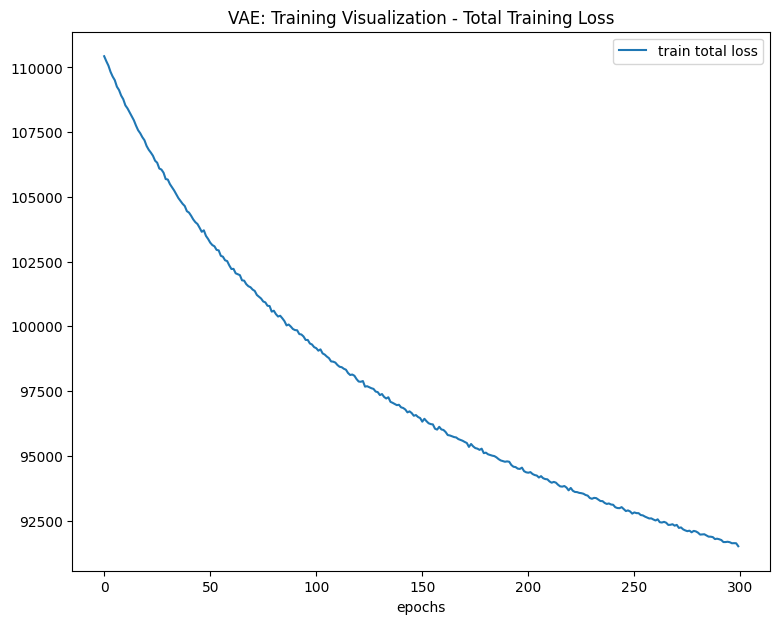

In [ ]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['total_loss'] for e in training_metrics.keys()], label = 'train total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Total Training Loss")
plt.show()

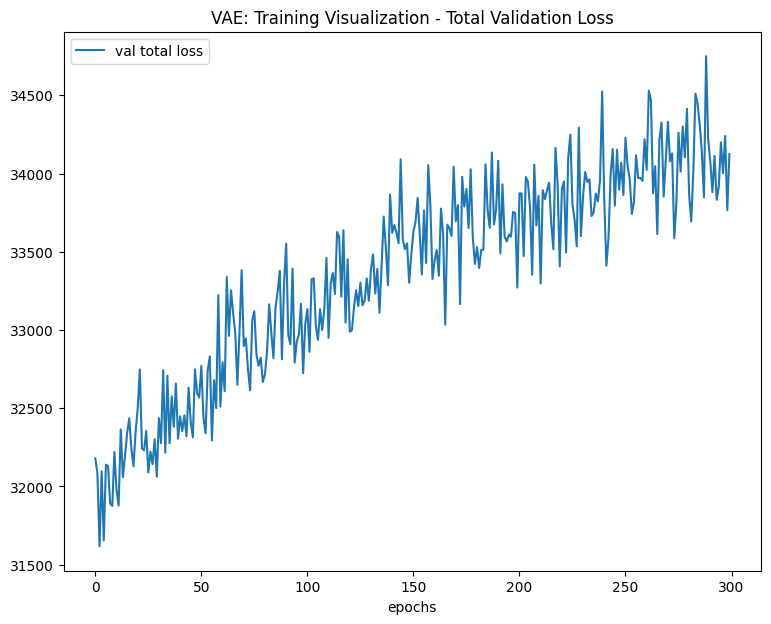

In [ ]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['total_loss'] for e in val_metrics.keys()], label = 'val total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Total Validation Loss")
plt.show()

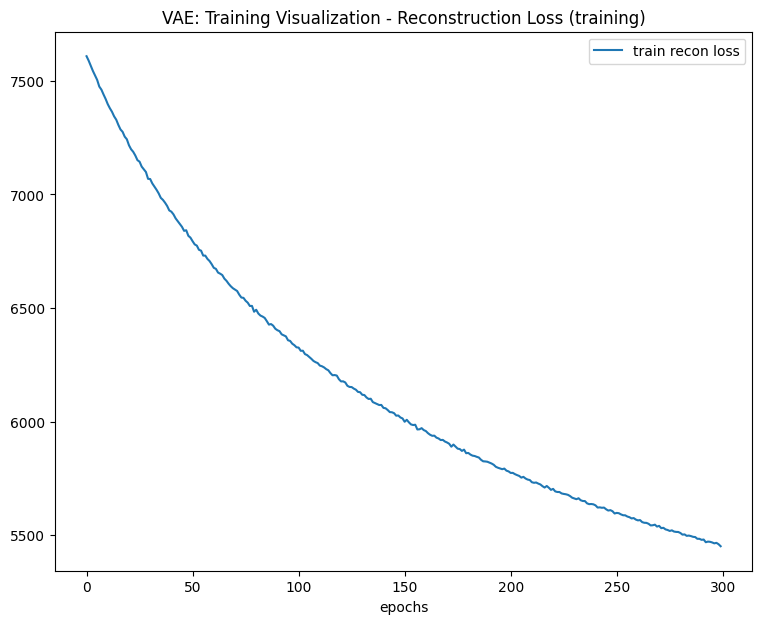

In [ ]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['recon_loss'] for e in training_metrics.keys()], label = 'train recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Reconstruction Loss (training)")
plt.show()

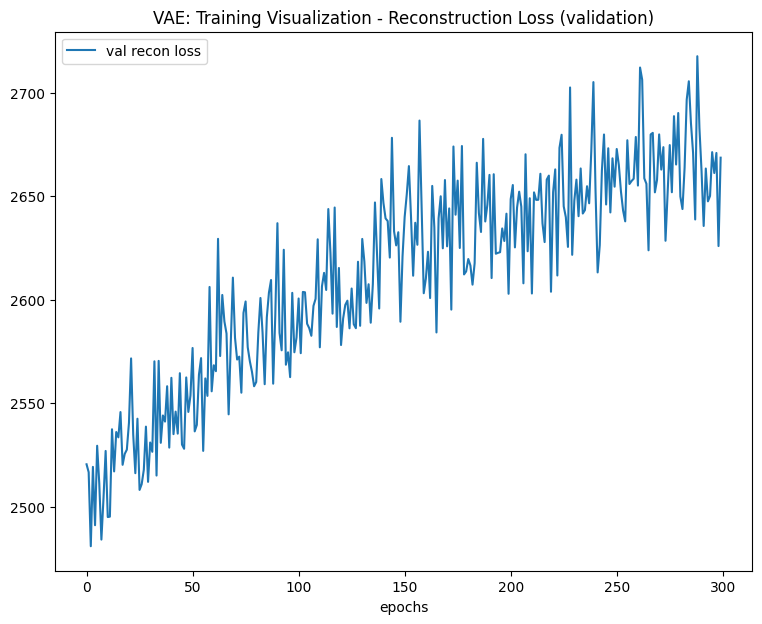

In [ ]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['recon_loss'] for e in val_metrics.keys()], label = 'val recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Reconstruction Loss (validation)")
plt.show()

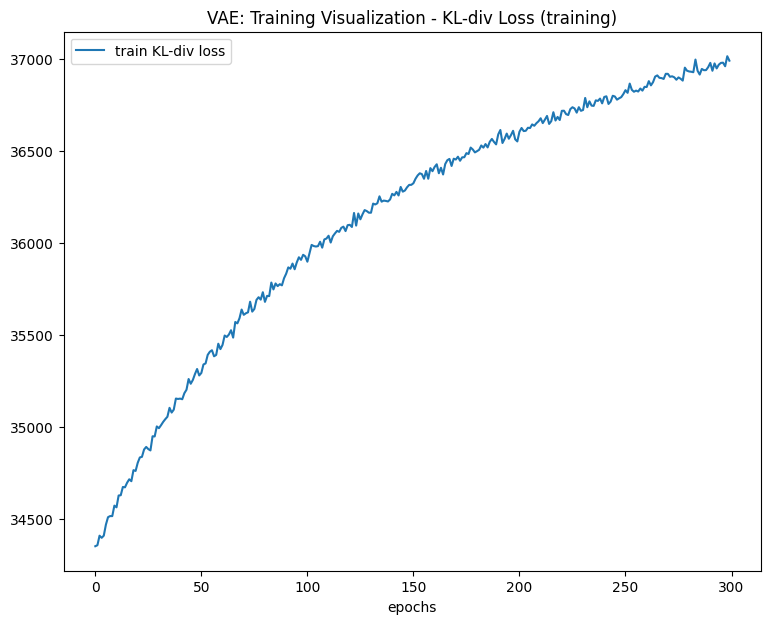

In [ ]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['kl_loss'] for e in training_metrics.keys()], label = 'train KL-div loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - KL-div Loss (training)")
plt.show()

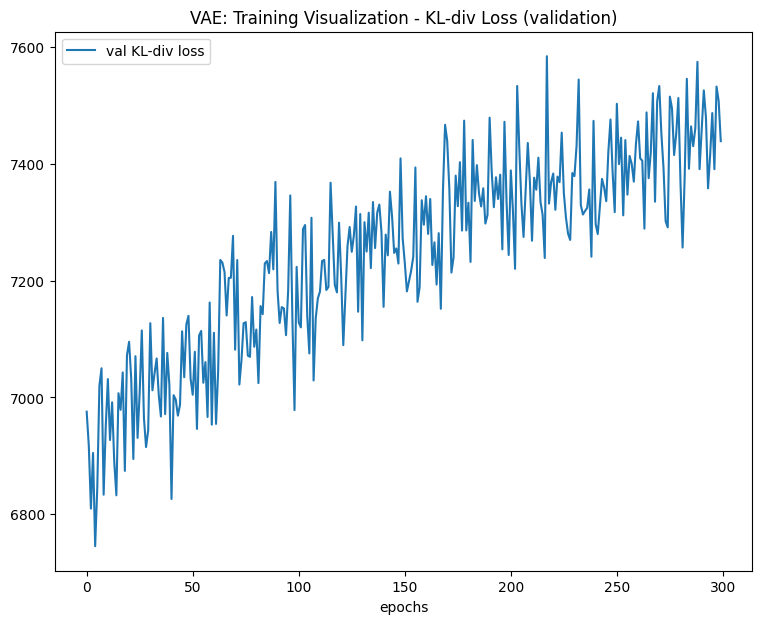

In [ ]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['kl_loss'] for e in val_metrics.keys()], label = 'val KL-div loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - KL-div Loss (validation)")
plt.show()

### Visualize _reconstructions_ using trained VAE model

In [ ]:
# Get reconstructions, mean & log-variance from trained model-
X_train_reconstruced, mu, log_var = model(X_train[:1000, :])

In [ ]:
# Sanity check-
X_train[:1000, :].shape, X_train_reconstruced.shape

((1000, 32, 32, 3), TensorShape([1000, 32, 32, 3]))

In [ ]:
# Sanity check-
X_train_reconstruced.numpy().shape

(1000, 32, 32, 3)

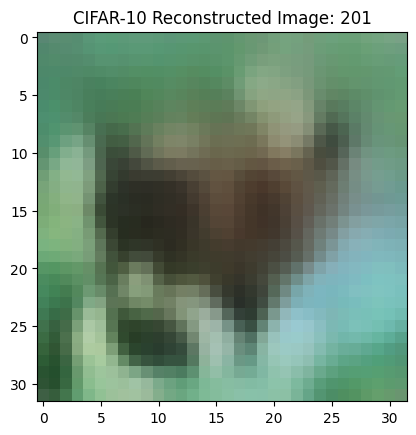

In [ ]:
# Visualize one of reconstructed CIFAR-10 image-
img_idx = 200

plt.imshow(X_train_reconstruced[img_idx])
plt.title(f"CIFAR-10 Reconstructed Image: {img_idx + 1}")
plt.show()

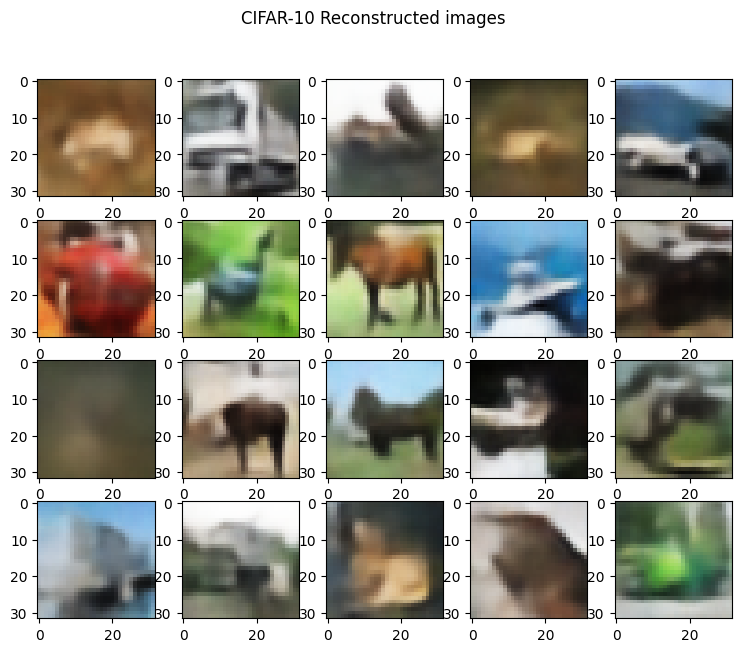

In [ ]:
# Visualize 20 reconstruced images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train_reconstruced[i])

plt.suptitle("CIFAR-10 Reconstructed images")
plt.savefig('VAE_CIFAR10_Reconstructed_Images2.png')
plt.show()

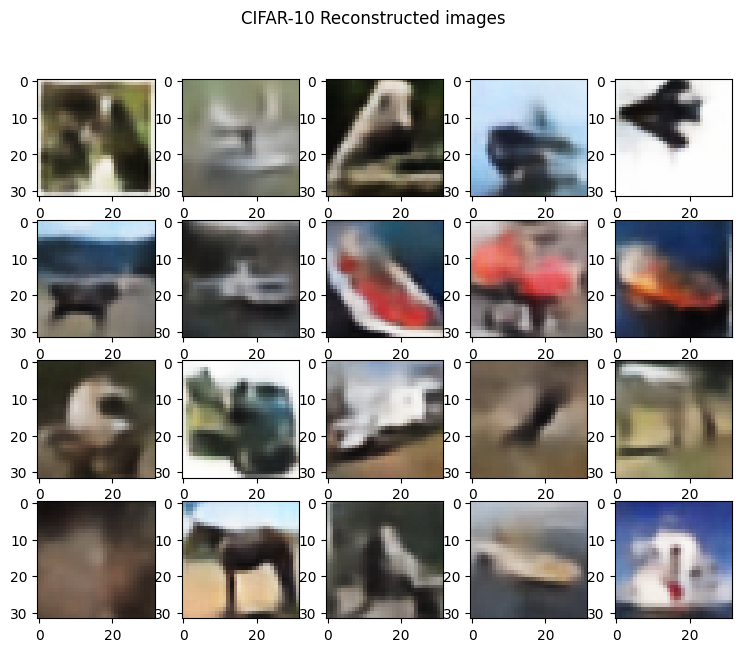

In [ ]:
# Visualize 20 reconstruced images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train_reconstruced[i + 500])

plt.suptitle("CIFAR-10 Reconstructed images")
plt.savefig('VAE_CIFAR10_Reconstructed_Images3.png')
plt.show()

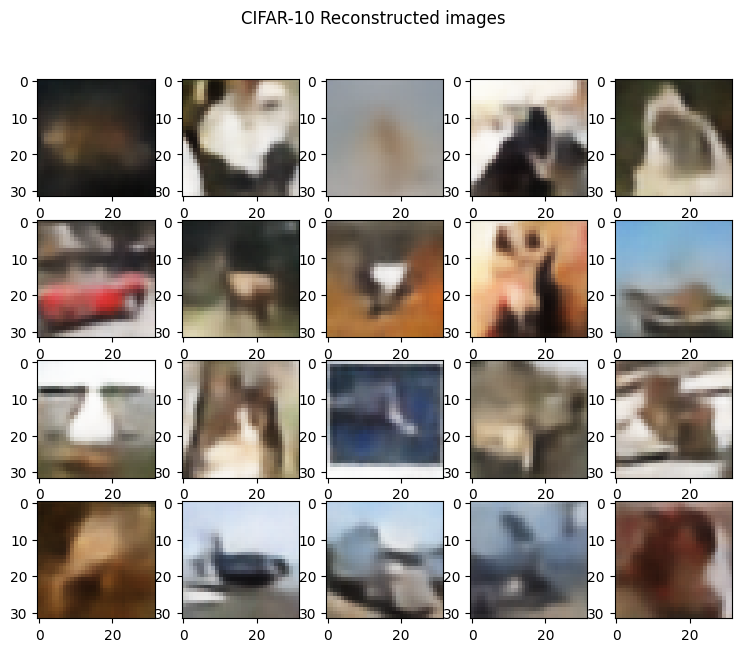

In [ ]:
# Visualize 20 reconstruced images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train_reconstruced[i + 850])

plt.suptitle("CIFAR-10 Reconstructed images")
plt.savefig('VAE_CIFAR10_Reconstructed_Images4.png')
plt.show()

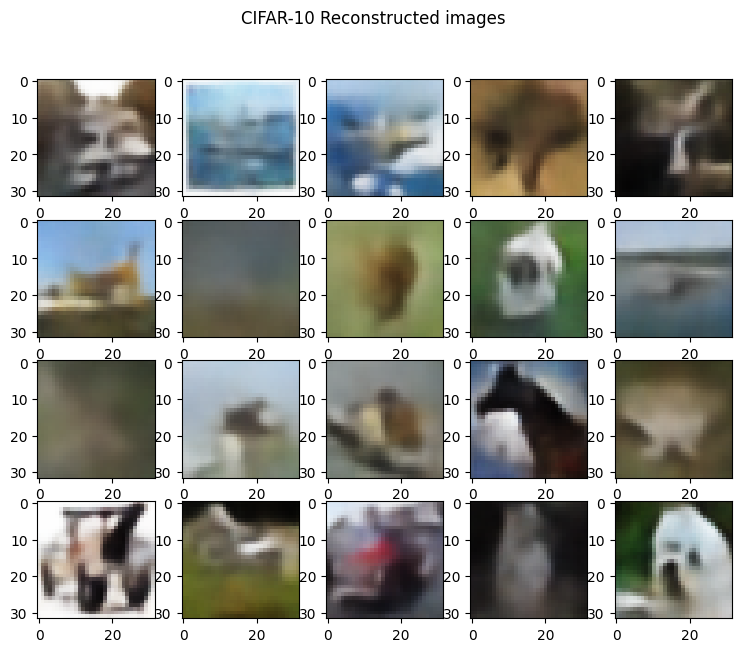

In [ ]:
# Visualize 20 reconstruced images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train_reconstruced[i + 900])

plt.suptitle("CIFAR-10 Reconstructed images")
plt.savefig('VAE_CIFAR10_Reconstructed_Images5.png')
plt.show()

#### Check _mu_ and _log_var_ latent space vectors:

In [ ]:
mu.shape, log_var.shape

(TensorShape([1000, 100]), TensorShape([1000, 100]))

In [ ]:
print(f"mu: mean = {mu.numpy().mean():.4f} & "
f"std dev = {mu.numpy().std():.4f}")

mu: mean = 0.0023 & std dev = 0.5060


In [ ]:
print(f"log var: mean = {log_var.numpy().mean():4f} &"
f" std dev = {log_var.numpy().std():.4f}")

log var: mean = -0.954289 & std dev = 1.6971


In [ ]:
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

In [ ]:
y_train.shape, y_test.shape

((50000,), (10000,))

In [ ]:
# Visualize  latent space mean-
fig = px.scatter_3d(
    x = mu[:, 0], y = mu[:, 1],
    z = mu[:, 2],
    color = y_train[:1000]
    )
fig.show()

In [ ]:
# Visualize  latent space log variance-
fig = px.scatter_3d(
    x = log_var[:, 0], y = log_var[:, 1],
    z = log_var[:, 2],
    color = y_train[:1000]
    )
fig.show()

In [ ]:
del mu, log_var, X_train_reconstruced

In [ ]:
X_train_encoded = model.encoder(X_train[:5000])
X_test_encoded = model.encoder(X_test[:5000])

In [ ]:
X_train_encoded.shape, X_test_encoded.shape

(TensorShape([5000, 100]), TensorShape([5000, 100]))

In [ ]:
X_train_encoded.numpy().mean(), X_train_encoded.numpy().std()

(1.0993164, 1.285875)

In [ ]:
X_test_encoded.numpy().mean(), X_test_encoded.numpy().std()

(1.0981687, 1.2836329)

In [ ]:
for i in range(100):
    print(f"i: {i} has mean = {X_train_encoded[:, i].numpy().mean():.3f} &"
          f" std dev = {X_train_encoded[:, i].numpy().std():.3f}"
         )

i: 0 has mean = 2.136 & std dev = 0.823
i: 1 has mean = 2.108 & std dev = 0.741
i: 2 has mean = 0.000 & std dev = 0.000
i: 3 has mean = 0.000 & std dev = 0.000
i: 4 has mean = 1.891 & std dev = 0.763
i: 5 has mean = 2.553 & std dev = 0.963
i: 6 has mean = 0.000 & std dev = 0.000
i: 7 has mean = 2.122 & std dev = 0.837
i: 8 has mean = 2.277 & std dev = 0.825
i: 9 has mean = 2.134 & std dev = 0.766
i: 10 has mean = 0.000 & std dev = 0.000
i: 11 has mean = 0.000 & std dev = 0.000
i: 12 has mean = 0.000 & std dev = 0.000
i: 13 has mean = 0.000 & std dev = 0.000
i: 14 has mean = 0.000 & std dev = 0.000
i: 15 has mean = 0.000 & std dev = 0.000
i: 16 has mean = 0.000 & std dev = 0.000
i: 17 has mean = 1.873 & std dev = 0.784
i: 18 has mean = 2.625 & std dev = 0.952
i: 19 has mean = 0.000 & std dev = 0.000
i: 20 has mean = 2.435 & std dev = 0.867
i: 21 has mean = 2.440 & std dev = 0.938
i: 22 has mean = 0.000 & std dev = 0.000
i: 23 has mean = 2.666 & std dev = 0.971
i: 24 has mean = 1.962 & s

In [ ]:
for i in range(100):
    print(f"i: {i} has mean = {X_test_encoded[:, i].numpy().mean():.3f} &"
          f" std dev = {X_test_encoded[:, i].numpy().std():.3f}"
         )

i: 0 has mean = 2.148 & std dev = 0.809
i: 1 has mean = 2.111 & std dev = 0.733
i: 2 has mean = 0.000 & std dev = 0.000
i: 3 has mean = 0.000 & std dev = 0.000
i: 4 has mean = 1.932 & std dev = 0.742
i: 5 has mean = 2.531 & std dev = 0.958
i: 6 has mean = 0.000 & std dev = 0.000
i: 7 has mean = 2.108 & std dev = 0.831
i: 8 has mean = 2.265 & std dev = 0.819
i: 9 has mean = 2.111 & std dev = 0.767
i: 10 has mean = 0.000 & std dev = 0.000
i: 11 has mean = 0.000 & std dev = 0.000
i: 12 has mean = 0.000 & std dev = 0.000
i: 13 has mean = 0.000 & std dev = 0.000
i: 14 has mean = 0.000 & std dev = 0.000
i: 15 has mean = 0.000 & std dev = 0.000
i: 16 has mean = 0.000 & std dev = 0.000
i: 17 has mean = 1.876 & std dev = 0.785
i: 18 has mean = 2.625 & std dev = 0.975
i: 19 has mean = 0.000 & std dev = 0.000
i: 20 has mean = 2.395 & std dev = 0.883
i: 21 has mean = 2.461 & std dev = 0.929
i: 22 has mean = 0.000 & std dev = 0.000
i: 23 has mean = 2.642 & std dev = 0.980
i: 24 has mean = 1.938 & s